<a href="https://colab.research.google.com/github/honeybeat1/webtoon-style-detector/blob/main/project4_with_3_lables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
from os import walk
from random import sample
from matplotlib.pyplot import imread
from skimage.transform import resize
import pickle, cv2
from sklearn.preprocessing import LabelEncoder

## Image preprocessing

In [6]:
img_root = "./gdrive/MyDrive/images/"

In [5]:
labels = [f for f in os.listdir(img_root) if not os.path.isfile(os.path.join(img_root, f))]
image_list = []
label_list = []
for label in labels:
  folder_path = '{}{}{}'.format(img_root, label, '/')
  images_folders = [f for f in os.listdir(folder_path) if not os.path.isfile(os.path.join(folder_path, f))]
  for images_folder in images_folders:
    image_folder_path = '{}{}{}'.format(folder_path, images_folder, '/')
    for f in os.listdir(image_folder_path):
      if f != '.DS_Store':
        image_path = '{}{}'.format(image_folder_path, f)
        image_list.append(image_path)
        label_list.append(label)
print(len(image_list), len(label_list))

3238 3238


In [6]:
df = pd.DataFrame({'img_path':image_list, 'class':label_list})
df.head()

,img_path,class
0,./gdrive/MyDrive/images/10level/2부 88화 - 싸ᄋ...,10level
1,./gdrive/MyDrive/images/10level/2부 88화 - 싸ᄋ...,10level
2,./gdrive/MyDrive/images/10level/2부 88화 - 싸ᄋ...,10level
3,./gdrive/MyDrive/images/10level/2부 88화 - 싸ᄋ...,10level
4,./gdrive/MyDrive/images/10level/2부 88화 - 싸ᄋ...,10level


In [ ]:
# class numerical하게 바꾸기
# 한글로 쓰면 못 잡길래 저런식으로 바꿔줌;
df['class'] = df['class'].map({df['class'][0]:0, df['class'][999]:1, df['class'][1700]:2})
df.head()

,img_path,class
0,./gdrive/MyDrive/images/remarry/73화/8.png,0.0
1,./gdrive/MyDrive/images/remarry/73화/48.png,0.0
2,./gdrive/MyDrive/images/remarry/73화/58.png,0.0
3,./gdrive/MyDrive/images/remarry/73화/49.png,0.0
4,./gdrive/MyDrive/images/remarry/73화/29.png,0.0


In [7]:
df['class'].unique()

array(['10level', 'remarry', 'revolution'], dtype=object)

In [8]:
df['class'].value_counts()

10level       1363
remarry        972
revolution     903
Name: class, dtype: int64

In [9]:
df.to_pickle('gdrive/MyDrive/Data/paths_classes_03.pkl')

In [14]:
def sampled_paths_classes(df):
    # encode art categories as numerical values
    encoder = LabelEncoder()
    y = encoder.fit_transform(df['class'].astype('str'))
    n_classes = len(np.unique(y))
    paths_and_classes = list(zip(df['img_path'].tolist(), y))
    print(n_classes)
    paths_and_classes_small = []
    for x in range(n_classes):
        temp = [(path, style) for path, style in paths_and_classes if style == x]
        #samp = sample(temp, 490)
        for path, style in temp:
            paths_and_classes_small.append((path,style))

    np.random.shuffle(paths_and_classes_small)

    return paths_and_classes_small, encoder.classes_

In [12]:
def prepare_image(image, target_width=224, target_height=224, max_zoom=0.2):
    height = image.shape[0]
    width = image.shape[0]

    image_ratio = width / height
    target_image_ratio = target_width / target_height
    
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height

    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)

    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height

    image = image[y0:y1, x0:x1]

    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    try:
      image = cv2.resize(image, (target_width, target_height))
    except:
      print("error")
      pass
    return image.astype(np.float32) / 255

In [13]:
def prepare_data():
  df = pd.read_pickle('gdrive/MyDrive/Data/paths_classes_03.pkl')
  
  paths_and_classes_small, class_names = sampled_paths_classes(df)
  print("==1 finished==")
  with open('gdrive/MyDrive/Data/paths_and_classes_small.pkl', 'wb') as f:
      pickle.dump(paths_and_classes_small, f)
  print("==2 finished==")
  class_dict = {index: art_class for index, art_class in zip(range(3), class_names)}
  print(class_dict)
  with open('gdrive/MyDrive/Data/class_dict.pkl', 'wb') as f:
      pickle.dump(class_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
  print("==3 finished==")
  
  images = []

  for path, label in paths_and_classes_small:
    images.append(cv2.imread(path, 1))
    print(path, label)

  #images = [cv2.imread(path,1) for path, label in paths_and_classes_small]

  x = np.array([prepare_image(image) for image in images])
  y = np.array([style for path, style in paths_and_classes_small])
  
  return x, y

In [ ]:
x, y = prepare_data()

In [14]:
np.savez('gdrive/MyDrive/Data/images_labels_224.npz', x=x, y=y)
print("Saved in a .npz file")

Saved in a .npz file


In [15]:
len(x)

3238

In [16]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 1363, 1: 972, 2: 903}

# Train - CNN with ResNet50

In [29]:
import numpy as np
import pandas as pd
from random import sample
import pickle, cv2

from matplotlib.pyplot import imread
import matplotlib.pyplot as plt

import sklearn
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics

from keras import applications, optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.models import model_from_json
from keras.models import load_model
from keras.utils import plot_model

import json

In [25]:
def train_validation_split(x, y):
    X_training, X_test, y_training, y_test = train_test_split(x, y, stratify=y, random_state=1337)
    X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, stratify=y_training, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [26]:
def one_hot(y_train, y_val, y_test, n_classes):
    y_train = np_utils.to_categorical(y_train, n_classes)
    y_val = np_utils.to_categorical(y_val, n_classes)
    y_test = np_utils.to_categorical(y_test, n_classes)

    return y_train, y_val, y_test

In [27]:
def build_fit_save_cnn(input_shape, n_classes, epochs, batch_size, X_train, X_val, y_train, y_val):
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dropout(0.25))
    add_model.add(Dense(n_classes, activation='softmax'))

    # combine base model and fully connected layers
    final_model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    # specify SDG optimizer parameters
    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

    # compile model
    final_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    history = final_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                              verbose=1, validation_data=(X_val, y_val))

    score = final_model.evaluate(X_val, y_val, verbose=0)
    print('Val. score:', score[0])
    print('Val. accuracy:', score[1])
    
    #plot_model(final_model, to_file='gdrive/MyDrive/Data/CNN-ResNet50-Kaggle-Model.svg')
    show_history(history)
    save_model(final_model,history)

    return final_model

In [23]:
def test_predict_score(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    test_pred = model.predict(X_test)

    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    return test_pred, score

Epoch 1/20
73/73 [==============================] - 18s 180ms/step - loss: 0.7071 - accuracy: 0.7373 - val_loss: 2.2438 - val_accuracy: 0.2801
Epoch 2/20
73/73 [==============================] - 12s 167ms/step - loss: 0.0416 - accuracy: 0.9832 - val_loss: 2.6976 - val_accuracy: 0.2998
Epoch 3/20
73/73 [==============================] - 12s 168ms/step - loss: 0.0131 - accuracy: 0.9963 - val_loss: 1.7441 - val_accuracy: 0.2998
Epoch 4/20
73/73 [==============================] - 12s 168ms/step - loss: 0.0150 - accuracy: 0.9929 - val_loss: 2.5938 - val_accuracy: 0.2998
Epoch 5/20
73/73 [==============================] - 12s 168ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 3.8763 - val_accuracy: 0.2998
Epoch 6/20
73/73 [==============================] - 12s 167ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 3.9958 - val_accuracy: 0.2998
Epoch 7/20
73/73 [==============================] - 12s 168ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.3600 - val_accuracy: 0.3839

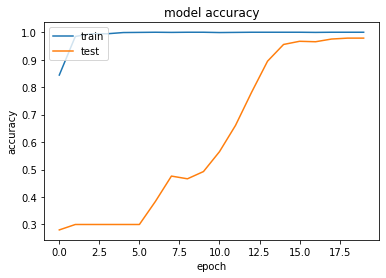

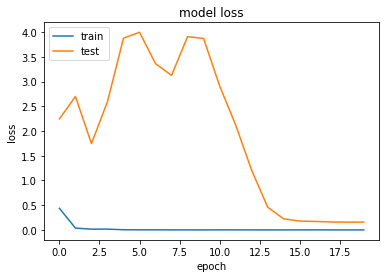

Model saved to disk!
History saved to disk!
Test score: 0.10128432512283325
Test accuracy: 0.9753086566925049


In [33]:
seed = 42
np.random.seed(seed)

epochs = 20
batch_size = 25
input_shape = (224,224,3)

data = np.load('gdrive/MyDrive/Data/images_labels_224.npz')
x = data['x']
y = data['y']
n_classes = len(np.unique(y))

X_train, X_val, X_test, y_train, y_val, y_test = train_validation_split(x, y)
y_train, y_val, y_test = one_hot(y_train, y_val, y_test, n_classes)
final_model = build_fit_save_cnn(input_shape, n_classes, epochs, batch_size, X_train, X_val, y_train, y_val)
test_pred, score = test_predict_score(final_model, X_test, y_test)

In [34]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [31]:
def save_model(model,history):
    
    open('gdrive/MyDrive/Saved_models/CNN-ResNet50-Kaggle.json', 'w').close()
    open('gdrive/MyDrive/Saved_models/CNN-ResNet50-Kaggle-weights.h5', 'w').close()
    
    model_json = model.to_json()
    with open('gdrive/MyDrive/Saved_models/CNN-ResNet50-Kaggle.json', 'w') as json_file:
        json_file.write(model_json)

    model.save_weights('gdrive/MyDrive/Saved_models/CNN-ResNet50-Kaggle-weights.h5')
    print('Model saved to disk!')
    
    with open('gdrive/MyDrive/Data/CNN-ResNet50-Kaggle-History.json', 'w') as f:
        json.dump(history.history, f)
    print('History saved to disk!')

In [32]:
def show_history(history):
    print(history.history.keys())
# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Predict

In [8]:
import numpy as np
from sys import argv
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
import pickle, cv2
from keras import optimizers
from keras.models import load_model
from keras.models import model_from_json

In [35]:
def load_model():
    json_file = open('gdrive/MyDrive/Saved_models/CNN-ResNet50-Kaggle.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('gdrive/MyDrive/Saved_models/CNN-ResNet50-Kaggle-weights.h5')

    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return loaded_model

In [36]:
def make_prediction(img_path):
    model = load_model()

    with open('gdrive/MyDrive/Data/class_dict.pkl', 'rb') as f:
        class_dict = pickle.load(f)
    print(class_dict)
    image = cv2.imread(img_path, 1)
    plt.imshow(image)
    image = prepare_image(image)
    images = []
    images.append(image)
    images = np.array(images)
    image_size = 224
    n_channels = 3
    X_batch = images.reshape(1, image_size, image_size, n_channels)

    preds = model.predict(X_batch)

    top_3 = np.argpartition(preds[0], -3)[-3:]
    top_3 = reversed(top_3[np.argsort(preds[0][top_3])])
    print('Top 3 Predictions:')
    print('------------------')
    for i in top_3:
        print('{0}: {1:.2f}%'.format(class_dict[i], 100 * preds[0][i]))

{0: '10level', 1: 'remarry', 2: 'revolution'}
Top 3 Predictions:
------------------
10level: 99.99%
remarry: 0.01%
revolution: 0.00%


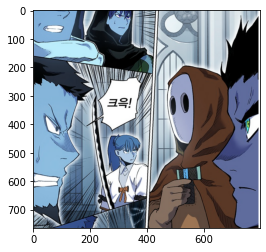

In [17]:
if __name__ == '__main__':
    img_path = "./gdrive/MyDrive/111.png"
    make_prediction(img_path)

{0: '10level', 1: 'remarry', 2: 'revolution'}
Top 3 Predictions:
------------------
remarry: 98.93%
10level: 1.06%
revolution: 0.01%


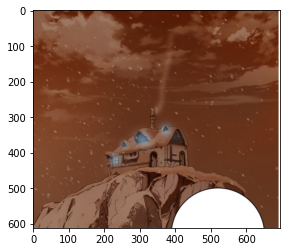

In [37]:
img_path = "./gdrive/MyDrive/112.png"
make_prediction(img_path)

{0: '10level', 1: 'remarry', 2: 'revolution'}
Top 3 Predictions:
------------------
remarry: 99.55%
10level: 0.45%
revolution: 0.00%


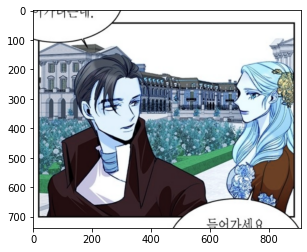

In [38]:
img_path = "./gdrive/MyDrive/remarry_test.png"
make_prediction(img_path)

{0: '10level', 1: 'remarry', 2: 'revolution'}
Top 3 Predictions:
------------------
remarry: 98.33%
10level: 1.67%
revolution: 0.00%


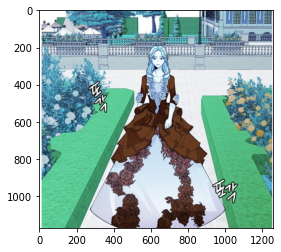

In [45]:
img_path = "./gdrive/MyDrive/remarry_test2.png"
make_prediction(img_path)

{0: '10level', 1: 'remarry', 2: 'revolution'}
Top 3 Predictions:
------------------
revolution: 60.84%
remarry: 39.16%
10level: 0.00%


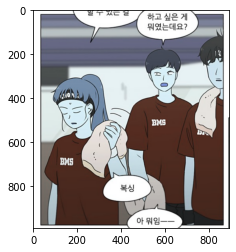

In [46]:
img_path = "./gdrive/MyDrive/rev.png"
make_prediction(img_path)

{0: '10level', 1: 'remarry', 2: 'revolution'}
Top 3 Predictions:
------------------
remarry: 74.18%
revolution: 25.82%
10level: 0.00%


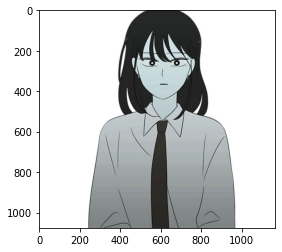

In [53]:
img_path = "./gdrive/MyDrive/113.png"
make_prediction(img_path)

In [43]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
#     classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title=title, 
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[333   6   2]
 [  8 232   3]
 [  0   1 225]]
Normalized confusion matrix
[[0.97653959 0.01759531 0.0058651 ]
 [0.03292181 0.95473251 0.01234568]
 [0.         0.00442478 0.99557522]]


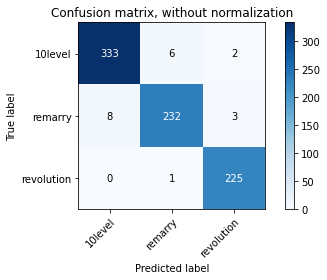

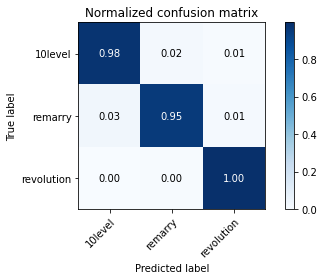

In [44]:
class_names = ["10level", "remarry", "revolution"]

y_pred = np.argmax(test_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)
    

plot_confusion_matrix(y_test_, y_pred, classes=class_names, title='Confusion matrix, without normalization')
plot_confusion_matrix(y_test_, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

---

## CNN - with VGG19 + Adam

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

directory = './gdrive/MyDrive/images/'

obj = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(256, 256), 
        batch_size = 2500)

Found 1756 images belonging to 3 classes.


In [ ]:
images, labels = obj.next()

FileNotFoundError: ignored

In [ ]:
images.shape, labels.shape

In [ ]:
x_test.shape, y_test.shape

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
#x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [ ]:
x_train.shape, x_test.shape, x_val.shape

((1404, 256, 256, 3), (176, 256, 256, 3), (176, 256, 256, 3))

In [ ]:
y_train.shape, y_test.shape, y_val.shape

((1404, 3), (176, 3), (176, 3))

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import regularizers

from keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from keras.applications import MobileNet, VGG19
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.activations import relu, tanh, sigmoid

from sklearn.metrics import confusion_matrix

In [ ]:
base_model=VGG19(weights='imagenet',include_top=False)
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(720,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(100, activation = 'relu')(x)
preds = Dense(3, activation='softmax')(x)

In [ ]:
model4=Model(inputs=base_model.input,outputs=preds)
for layer in model4.layers[:22]:
    layer.trainable=False
for layer in model4.layers[22:]:
    layer.trainable=True
model4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
results = model4.fit(x_train, y_train, epochs=15, batch_size=40, validation_data=(x_val, y_val))

Epoch 1/15
36/36 [==============================] - 11s 283ms/step - loss: 0.0663 - acc: 0.9765 - val_loss: 0.3254 - val_acc: 0.8807
Epoch 2/15
36/36 [==============================] - 10s 284ms/step - loss: 0.0561 - acc: 0.9829 - val_loss: 0.1471 - val_acc: 0.9489
Epoch 3/15
36/36 [==============================] - 10s 286ms/step - loss: 0.0346 - acc: 0.9893 - val_loss: 0.2147 - val_acc: 0.9432
Epoch 4/15
36/36 [==============================] - 10s 291ms/step - loss: 0.0678 - acc: 0.9765 - val_loss: 0.3107 - val_acc: 0.9205
Epoch 5/15
36/36 [==============================] - 10s 291ms/step - loss: 0.1052 - acc: 0.9608 - val_loss: 0.3440 - val_acc: 0.9091
Epoch 6/15
36/36 [==============================] - 10s 291ms/step - loss: 0.1373 - acc: 0.9487 - val_loss: 0.3217 - val_acc: 0.8977
Epoch 7/15
24/36 [===================>..........] - ETA: 3s - loss: 0.1111 - acc: 0.9583

KeyboardInterrupt: ignored

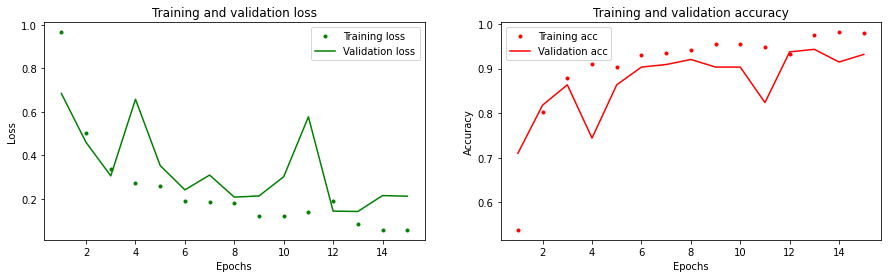

In [ ]:
hist = results.history
loss_values = hist['loss']
val_loss_values = hist['val_loss']
acc_values = hist['acc'] 
val_acc_values = hist['val_acc']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model4.save('model4.h5')
model4.save_weights('model4_weights.h5')

In [ ]:
model4 = load_model('model4.h5')
model4.load_weights('model4_weights.h5')
model4.evaluate(x_test, y_test)

6/6 [==============================] - 8s 158ms/step - loss: 0.1388 - acc: 0.9489


[0.13881538808345795, 0.9488636255264282]

In [ ]:
y_test

In [ ]:
model4.metrics_names

['loss', 'acc']

## AutoEncoder + Kmeans Clustering

In [60]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 100
batch_size = 256
save_dir = './gdrive/MyDrive/results'

In [62]:
from time import time

from keras.engine.topology import Layer, InputSpec

from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

In [57]:
def autoencoderConv2D_1(input_shape=(224, 224, 3), filters=[32, 64, 128, 3]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [58]:
autoencoder, encoder = autoencoderConv2D_1()

In [61]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/100
13/13 [==============================] - 7s 428ms/step - loss: 0.3476
Epoch 2/100
13/13 [==============================] - 5s 358ms/step - loss: 0.1640
Epoch 3/100
13/13 [==============================] - 5s 357ms/step - loss: 0.1336
Epoch 4/100
13/13 [==============================] - 5s 350ms/step - loss: 0.1308
Epoch 5/100
13/13 [==============================] - 5s 356ms/step - loss: 0.1297
Epoch 6/100
13/13 [==============================] - 5s 366ms/step - loss: 0.1300
Epoch 7/100
13/13 [==============================] - 5s 355ms/step - loss: 0.1305
Epoch 8/100
13/13 [==============================] - 4s 343ms/step - loss: 0.1304
Epoch 9/100
13/13 [==============================] - 5s 354ms/step - loss: 0.1302
Epoch 10/100
13/13 [==============================] - 5s 354ms/step - loss: 0.1285
Epoch 11/100
13/13 [==============================] - 5s 357ms/step - loss: 0.1295
Epoch 12/100
13/13 [==============================] - 5s 354ms/step - loss: 0.1297
Epoch 13/100


In [63]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

In [64]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

In [66]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)


    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [68]:
n_clusters = len(np.unique(y))
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [69]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

### Step 1: initialize cluster centers using k-means

In [70]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [71]:
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])


### Step 2: deep clustering
Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [72]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [76]:
loss = 0
index = 0
maxiter = 1000
update_interval = 100
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

### Start training

In [77]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.accuracy_score(y, y_pred), 5)
            nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

Iter 0: acc = 0.33879, nmi = 0.01246, ari = 0.01246  ; loss= 0
Iter 100: acc = 0.33601, nmi = 0.01470, ari = 0.01425  ; loss= 0.15978
Iter 200: acc = 0.33539, nmi = 0.01377, ari = 0.01358  ; loss= 0.05733
Iter 300: acc = 0.33632, nmi = 0.01393, ari = 0.01398  ; loss= 0.05464
Iter 400: acc = 0.33879, nmi = 0.01396, ari = 0.01419  ; loss= 0.05881
Iter 500: acc = 0.33817, nmi = 0.01399, ari = 0.01420  ; loss= 0.05218
Iter 600: acc = 0.33879, nmi = 0.01406, ari = 0.01433  ; loss= 0.05128
Iter 700: acc = 0.33817, nmi = 0.01402, ari = 0.01424  ; loss= 0.04677
delta_label  0.0006176652254478073 < tol  0.001
Reached tolerance threshold. Stopping training.


### Load the clustering model trained weights

In [78]:
model.load_weights(save_dir + '/DEC_model_final.h5')

### Final Evaluation

In [81]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.accuracy_score(y, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.33817, nmi = 0.01402, ari = 0.01424  ; loss= 0.04677


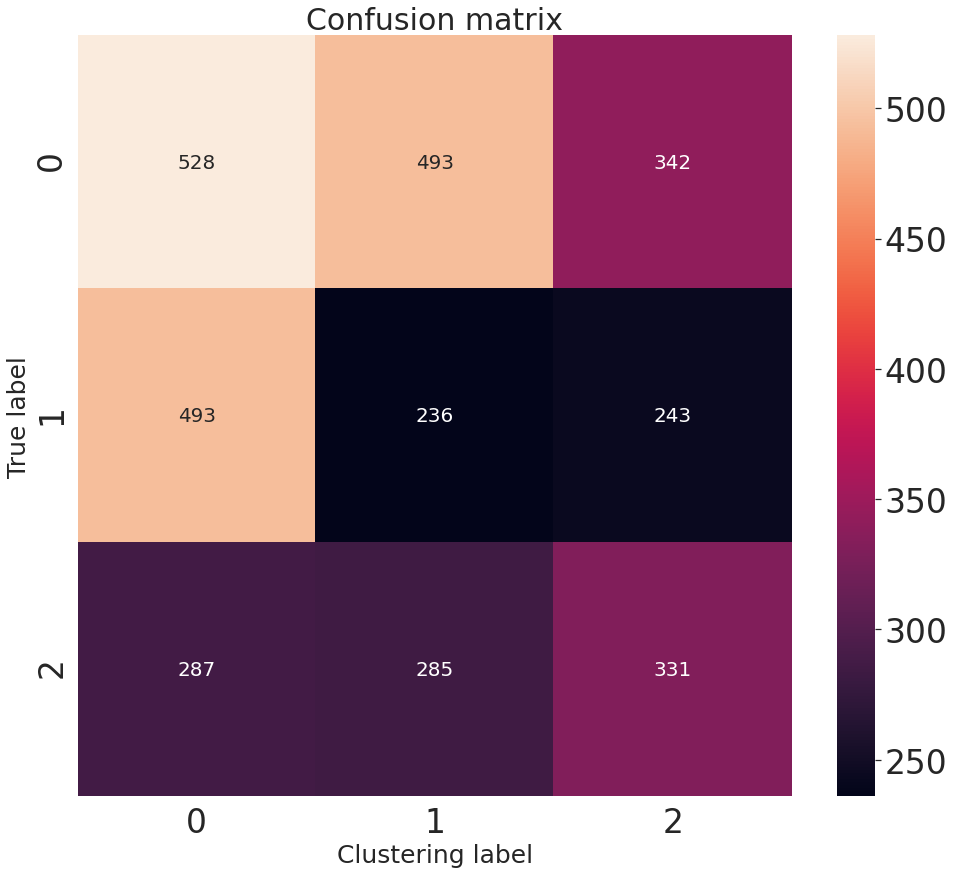

In [80]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()